In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d
import torch
from omegaconf import OmegaConf
from tqdm.notebook import tqdm, trange
from utils.data import load_xyz_file
from utils.losses import chamfer_dist, density_chamfer_dist
from utils.viz import viz_many, viz_many_mpl

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Jitting Chamfer 3D


/home/zademn/.conda/envs/pytorch_env/lib/python3.9/site-packages/torch/utils/cpp_extension.py:295: UserWarning: 

                               !! WARNING !!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Your compiler (c++) is not compatible with the compiler Pytorch was
built with for this platform, which is g++ on linux. Please
use g++ to to compile your extension. Alternatively, you may
compile PyTorch from source using c++, and then you can also use
c++ to compile your extension.

See https://github.com/pytorch/pytorch/blob/master/CONTRIBUTING.md for help
with compiling PyTorch from source.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

                              !! WARNING !!

  warnings.warn(WRONG_COMPILER_WARNING.format(


Loaded JIT 3D CUDA chamfer distance


# Load model

Load a model from checkpoint and evaluate with it 

In [2]:
sorted(os.listdir("trained-models/"))

['.ipynb_checkpoints',
 '2022-03-15-15-48-pool_max',
 '2022-03-15-22-45-pool_mean',
 '2022-03-16-09-00-pool_add',
 '2022-03-16-15-40-conv_gat',
 '2022-03-17-11-23-conv_edge',
 '2022-03-30-18-29-pugnn-gat-1',
 '2022-03-30-19-08-pugnn-gat-2-heads',
 '2022-03-30-20-11-pugnn-radius-0.25',
 '2022-04-05-16-58-pupt-baseline',
 '2022-04-05-19-29-pupt-baseline-refined',
 '2022-04-06-10-37-pugcn-baseline-refiner-transformer',
 '2022-04-06-11-50-pugcn-baseline',
 '2022-04-06-12-23-pugcn-baseline-36',
 '2022-04-06-13-10-pugcn-baseline-2idgcn',
 '2022-04-06-13-48-pugcn-baseline-3dilations',
 '2022-04-06-14-35-pupt-baseline-36',
 '2022-04-06-15-36-pupt-baseline-2ipt',
 '2022-04-06-16-12-pupt-baseline-3dilations',
 '2022-04-06-16-55-pupt-baseline',
 '2022-04-06-19-14-pupt-baseline-add-points',
 '2022-05-14-14-42-pupt-baseline',
 '2022-05-17-13-42-pugcn-baseline',
 '2022-05-17-14-59-pupt-baseline',
 '2022-05-17-17-07-pupt-baseline-no-refiner',
 '2022-05-17-17-41-pugcn-baseline-no-refiner',
 '2022-05-1

In [23]:
# d = os.listdir(os.path.join("trained-models"))[0]
ckpt_dir = sorted(os.listdir("trained-models"))[-9]

In [24]:
ckpt_dir

'2022-06-06-14-27-pugcn-baseline-hierarchical'

In [25]:
os.listdir(os.path.join("trained-models", ckpt_dir))

['ckpt_epoch_10', 'ckpt_epoch_1', 'ckpt_epoch_5', 'config.yaml']

In [26]:
exp_conf = OmegaConf.load(os.path.join("trained-models", ckpt_dir, "config.yaml"))
print(exp_conf)

{'name': 'pugcn-baseline-hierarchical', 'model_config': {'r': 4, 'k': 20, 'dilations': [1, 2], 'n_idgcn_blocks': 1, 'channels': 24, 'n_dgcn_blocks': 2, 'use_bottleneck': True, 'use_pooling': True, 'use_residual': True, 'conv': 'edge', 'pool_type': 'mean', 'dynamic': False, 'use_refiner': False, 'upsampler': 'nodeshuffle', 'hierarchical': True}, 'train_config': {'batch_size': 8, 'epochs': 10, 'optimizer': 'adam', 'lr': 0.001, 'betas': [0.9, 0.999], 'save_every': 5, 'augment': True, 'loss_fn': 'cd', 'k_loss': 4}, 'data_config': {'path': '../data/PU1K/train/pu1k_poisson_256_poisson_1024_pc_2500_patch50_addpugan.h5', 'num_point': 256, 'skip_rate': 1, 'use_randominput': True, 'rng_seed': 42}}


In [27]:
ckpt_name = "ckpt_epoch_10"

In [28]:
checkpoint = torch.load(os.path.join("trained-models", ckpt_dir, ckpt_name))

In [29]:
history = OmegaConf.create(checkpoint["history"])

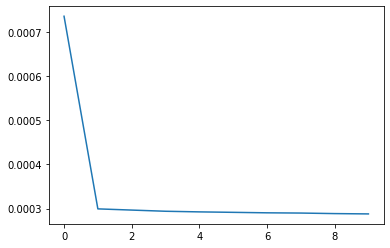

In [30]:
plt.plot(history.train_loss)

In [31]:
model_config = exp_conf.model_config

In [32]:
model_config

{'r': 4, 'k': 20, 'dilations': [1, 2], 'n_idgcn_blocks': 1, 'channels': 24, 'n_dgcn_blocks': 2, 'use_bottleneck': True, 'use_pooling': True, 'use_residual': True, 'conv': 'edge', 'pool_type': 'mean', 'dynamic': False, 'use_refiner': False, 'upsampler': 'nodeshuffle', 'hierarchical': True}

In [33]:
from pugcn_lib.models import PUGCN, JustUpsample, PUInceptionTransformer

In [34]:
model = PUGCN(**model_config)
# model = PUInceptionTransformer(**model_config)
# model = JustUpsample(**model_config)

model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

# Qualitative

In [35]:
input_dir = os.path.join("..", "data", "PU1K", "test", "input_256", "input_256")
gt_dir = os.path.join("..", "data", "PU1K", "test", "input_256", "gt_1024")

In [36]:
file = "horse.xyz"
data = load_xyz_file(os.path.join(input_dir, file))
gt = load_xyz_file(os.path.join(gt_dir, file))
data = torch.tensor(data, dtype=torch.float32)
gt = torch.tensor(gt, dtype=torch.float32)

In [37]:
out = model(data).detach()

In [38]:
# o3d
viz_many([data.numpy(), gt.numpy(), out.numpy()])

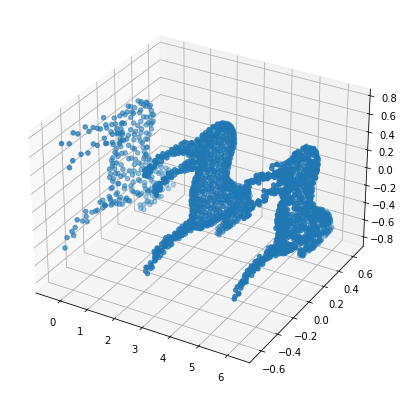

In [19]:
fig = plt.figure(figsize=(7, 7))
ax = plt.axes(projection="3d")
viz_many_mpl([data.numpy(), gt.numpy(), out.numpy()], ax=ax)

In [20]:
## Save pic
v = o3d.visualization.Visualizer()
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(data.numpy())
v.add_geometry(pcd)

False

In [21]:
# v.capture_screen_image("test.png")

# Quantitative

In [39]:
import torch
from einops import rearrange, reduce
from gcn_lib.sparse.torch_edge import Dilated

In [40]:
from time import time

from utils.losses import (
    chamfer_dist,
    chamfer_dist_repulsion,
    density_chamfer_dist,
    hausdorff_loss,
)

In [41]:
chamfer_losses = []
hausdorff_losses = []
dcds = []
for file in tqdm(os.listdir(input_dir)):
    # Load files
    data = load_xyz_file(os.path.join(input_dir, file))
    gt = load_xyz_file(os.path.join(gt_dir, file))
    data = torch.tensor(data, dtype=torch.float32)
    gt = torch.tensor(gt, dtype=torch.float32)
    # predict
    t = time()
    out = model(data)
    t = time() - t

    # chamfer
    dcd, _, cd = density_chamfer_dist(out.unsqueeze(0).cuda(), gt.unsqueeze(0).cuda(), alpha=1000, n_lambda=0.5)
    chamfer_losses.append(cd.item())
    dcds.append(dcd.item())

    # hausdorff

    loss = hausdorff_loss(out.detach(), gt.detach())
    hausdorff_losses.append(loss)

  0%|          | 0/127 [00:00<?, ?it/s]

In [42]:
print("CD = ", np.mean(chamfer_losses) * 10**3)
print("DCD = ", np.mean(dcds))
print("HD = ", np.mean(hausdorff_losses) * 10**3)
print("Inference time = ", t * 1000)
print("Model size = ", checkpoint["model_size"])

CD =  0.9151282833703962
DCD =  0.4014694742330416
HD =  54.31454253819575
Inference time =  15.903234481811523
Model size =  29.48


In [26]:
t = OmegaConf.create(
    {
        "epochs_trained": checkpoint["epoch"],
        "chamfer_loss": float(np.mean(chamfer_losses) * 10**3),
        "density_aware_chamfer_loss": float(np.mean(dcds) * 10**3),
        "hausdorff_loss": float(np.mean(hausdorff_losses) * 10**3),
        "model_size": checkpoint["model_size"],
        "inference_time": t,
    }
)

In [27]:
print(OmegaConf.to_yaml(exp_conf))

name: ju-baseline2
model_config:
  r: 4
  k: 20
  dilations:
  - 1
  - 2
  channels: 24
  conv: edge
  use_refiner: false
  upsampler: nodeshuffle
  hierarchical: false
  use_bottleneck: true
  use_global: true
train_config:
  batch_size: 8
  epochs: 10
  optimizer: adam
  lr: 0.001
  betas:
  - 0.9
  - 0.999
  save_every: 5
  augment: true
  loss_fn: cd
data_config:
  path: ../data/PU1K/train/pu1k_poisson_256_poisson_1024_pc_2500_patch50_addpugan.h5
  num_point: 256
  skip_rate: 1
  use_randominput: true
  rng_seed: 42



In [28]:
results = exp_conf
results.results = t

In [29]:
OmegaConf.save(config=results, f=os.path.join("results", f"results-{ckpt_dir}-{ckpt_name}.yaml"))